# Imports

In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools

## Extracting thermal conductivity from logfile


In [2]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

## Updating the seed for the random velocities in LAMMPS


In [3]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

## Updating the masses of the atoms in LAMMPS input script


In [4]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

## Updating dimensonality of LAMMPS input script

In [5]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

## Bash function

In [6]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

## Creating a LAMMPS-compatible datafile

In [7]:
def layered_datafile_creation(Ncells, Nlayers, spacings):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types = generate_FCC(Ncells, Nlayers, spacings)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return

In [8]:
def generate_FCC(Ncells, Nlayers, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes one type of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    Nlayers - number of layers along y (integer)
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers"""
    # Create storage arrays
    positions1, positions2 = [], []
    atom_types1, atom_types2 = [], []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    y_range = range(0, 2*Nlayers)

    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        # Check the first layer:
        if y%2 == 0:
            # Check if x+z is even
            if (x+z)%2 == 0:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2)*y_spacing
                # Append positions and types
                positions1.append([x,y,z])
                atom_types1.append(int(1))
                
        # Check the second layer
        elif y%2 == 1:
            # Check if x+z is odd
            if (x+z)%2 == 1:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2 + 0.5)*y_spacing
                # Append positions and types
                positions2.append([x,y,z])
                atom_types2.append(int(2))
                                    
    # Convert lists to arrays for plotting & return
    positions1 = np.array(positions1)
    positions2 = np.array(positions2)
    positions = np.concatenate( (positions1, positions2), axis=0 )
    atom_types1 = np.array(atom_types1)
    atom_types2 = np.array(atom_types2)
    atom_types = np.concatenate( (atom_types1, atom_types2), axis=0 )
    
    return positions, atom_types

## Nx6xN

In [9]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

N = np.array([2,3,4,5,6,7])

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for n in tqdm(N):
    # Create datafile for LAMMPS to use
    Ncells = np.array([n,n])
    layered_datafile_creation(Ncells, 6, spacings)
    # Update seeds
    seeds = np.random.randint(1,100000,20)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:02:21<00:00, 623.53s/it]


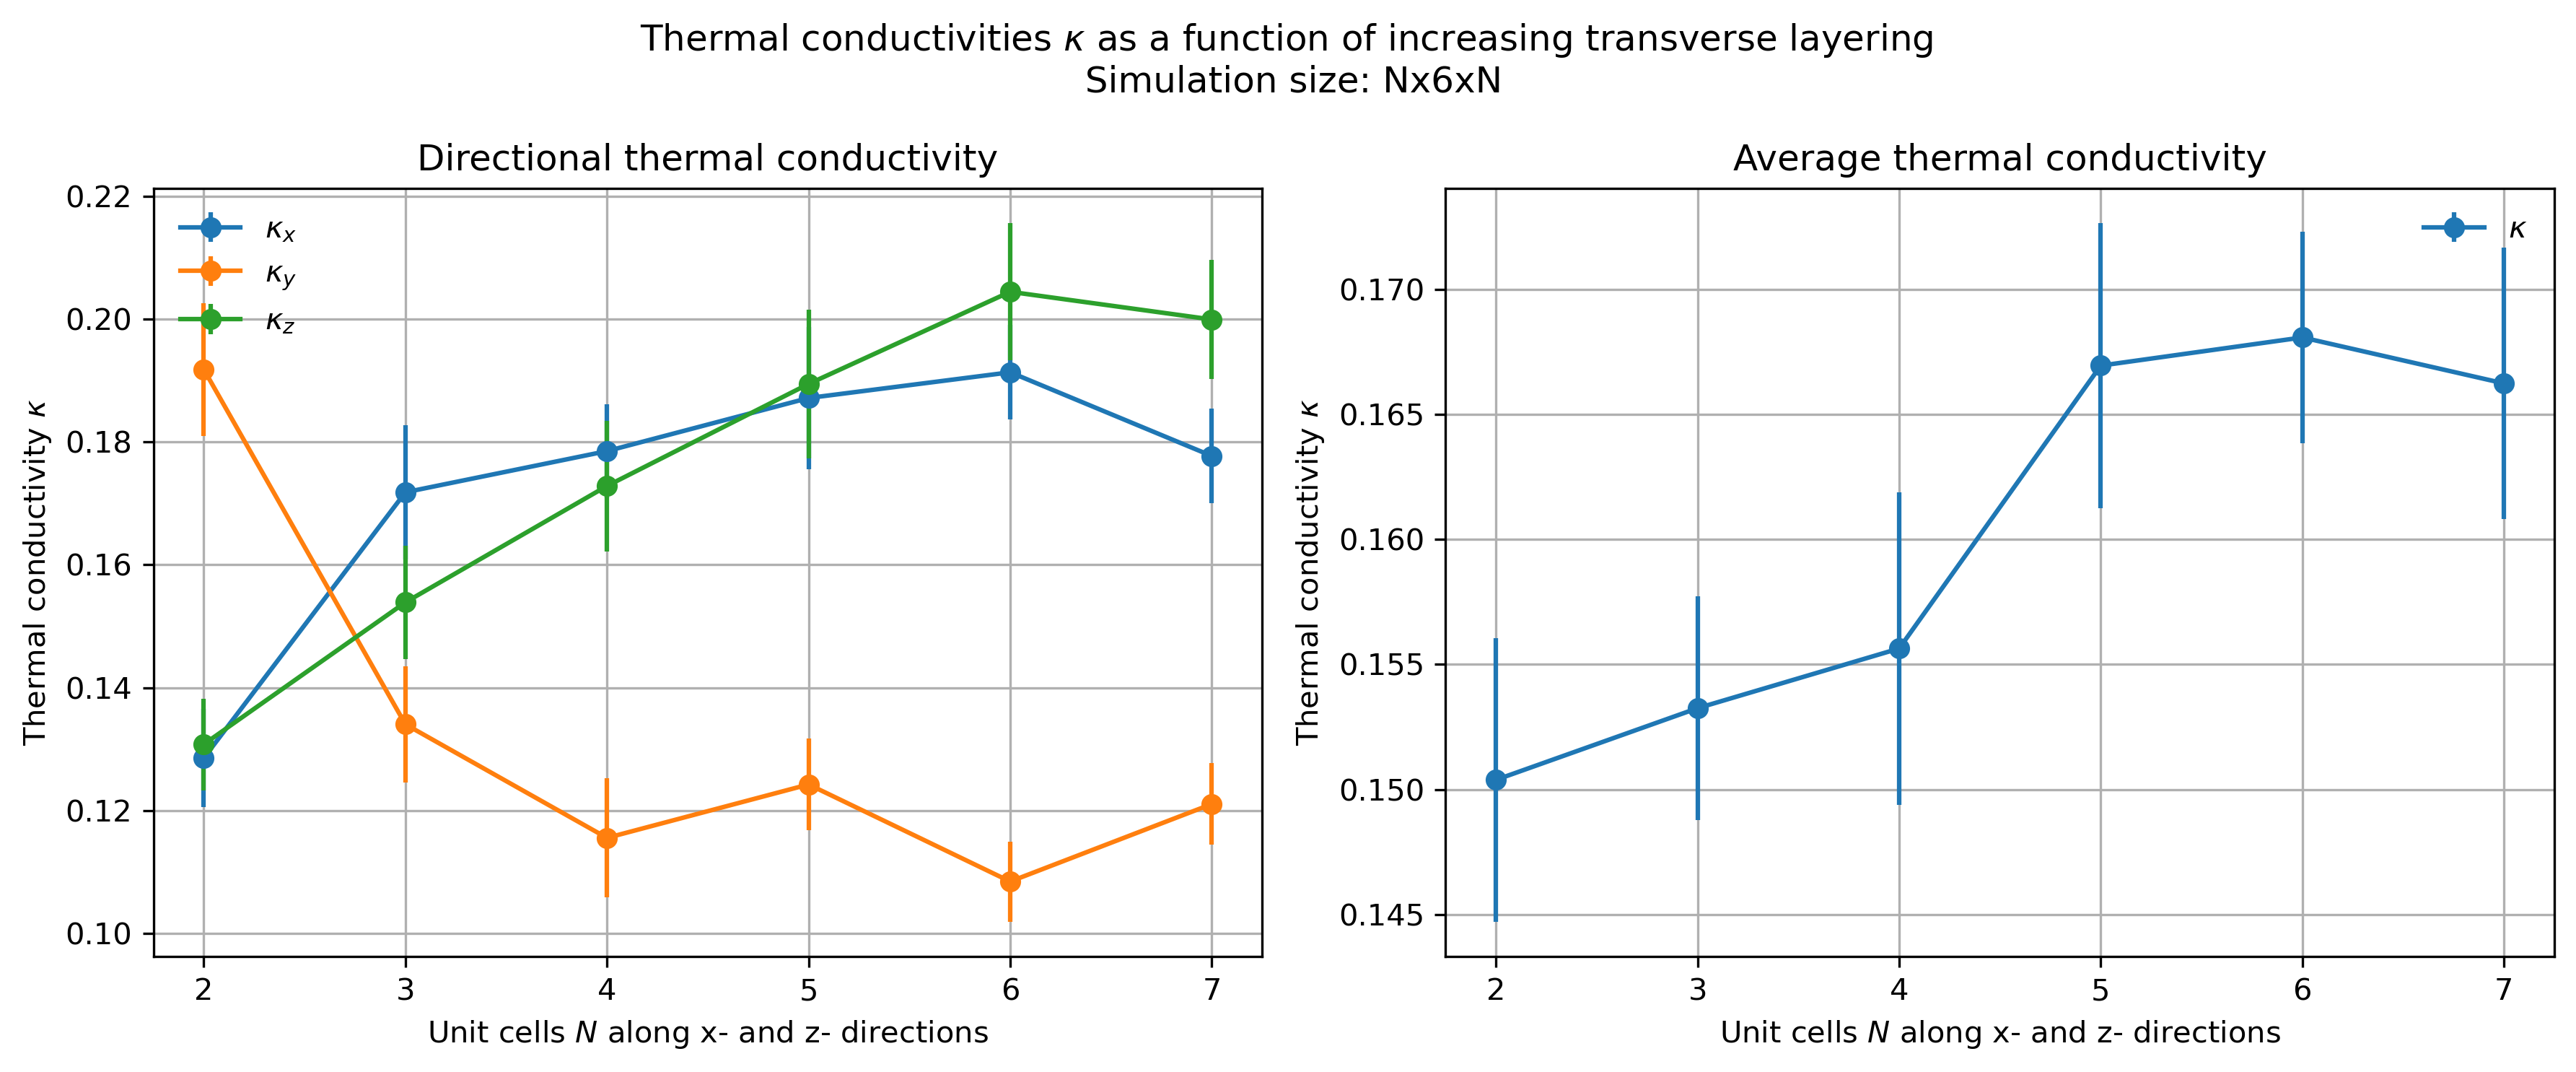

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot directional conductivities
ax1.errorbar(N, kx_averages, yerr=kx_errors, fmt='o-', label=r"$\kappa_x$")
ax1.errorbar(N, ky_averages, yerr=ky_errors, fmt='o-', label=r"$\kappa_y$")
ax1.errorbar(N, kz_averages, yerr=kz_errors, fmt='o-', label=r"$\kappa_z$")
ax1.grid()
ax1.set_xlabel("Unit cells $N$ along x- and z- directions"); ax1.set_ylabel("Thermal conductivity $\kappa$")
ax1.set_title("Directional thermal conductivity")
ax1.legend()

# Plot average conductivities
ax2.errorbar(N, k_averages, yerr=k_errors, fmt='o-', label=r"$\kappa$")
ax2.grid()
ax2.set_xlabel("Unit cells $N$ along x- and z- directions"); ax2.set_ylabel("Thermal conductivity $\kappa$")
ax2.set_title("Average thermal conductivity")
ax2.legend()

plt.suptitle("Thermal conductivities $\kappa$ as a function of increasing transverse layering \n Simulation size: Nx6xN")
plt.tight_layout()

The good thing is that the 2x6x2 gives the same results as the one we got for the 2-20 layer investigation. However, even though we did 4x as many seeds, the error bar width is only a factor of 2 smaller...

Why does the TC along y collapse from 2x6x2 to 3x6x3? Larger simulation cell means that the allowed k-values are smaller (2pi/L) so the phonon dispersion relation is more well-defined, which unlocks more modes. So here the unlocked modes along x and z decrease the thermal conductivity along y? Does this uncover Umklapp events which impede y-directional TC?

## Nx3xN

In [11]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

N = np.array([2,3,4,5,6,7])

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for n in tqdm(N):
    # Create datafile for LAMMPS to use
    Ncells = np.array([n,n])
    layered_datafile_creation(Ncells, 3, spacings)
    # Update seeds
    seeds = np.random.randint(1,100000,20)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [38:01<00:00, 380.25s/it]


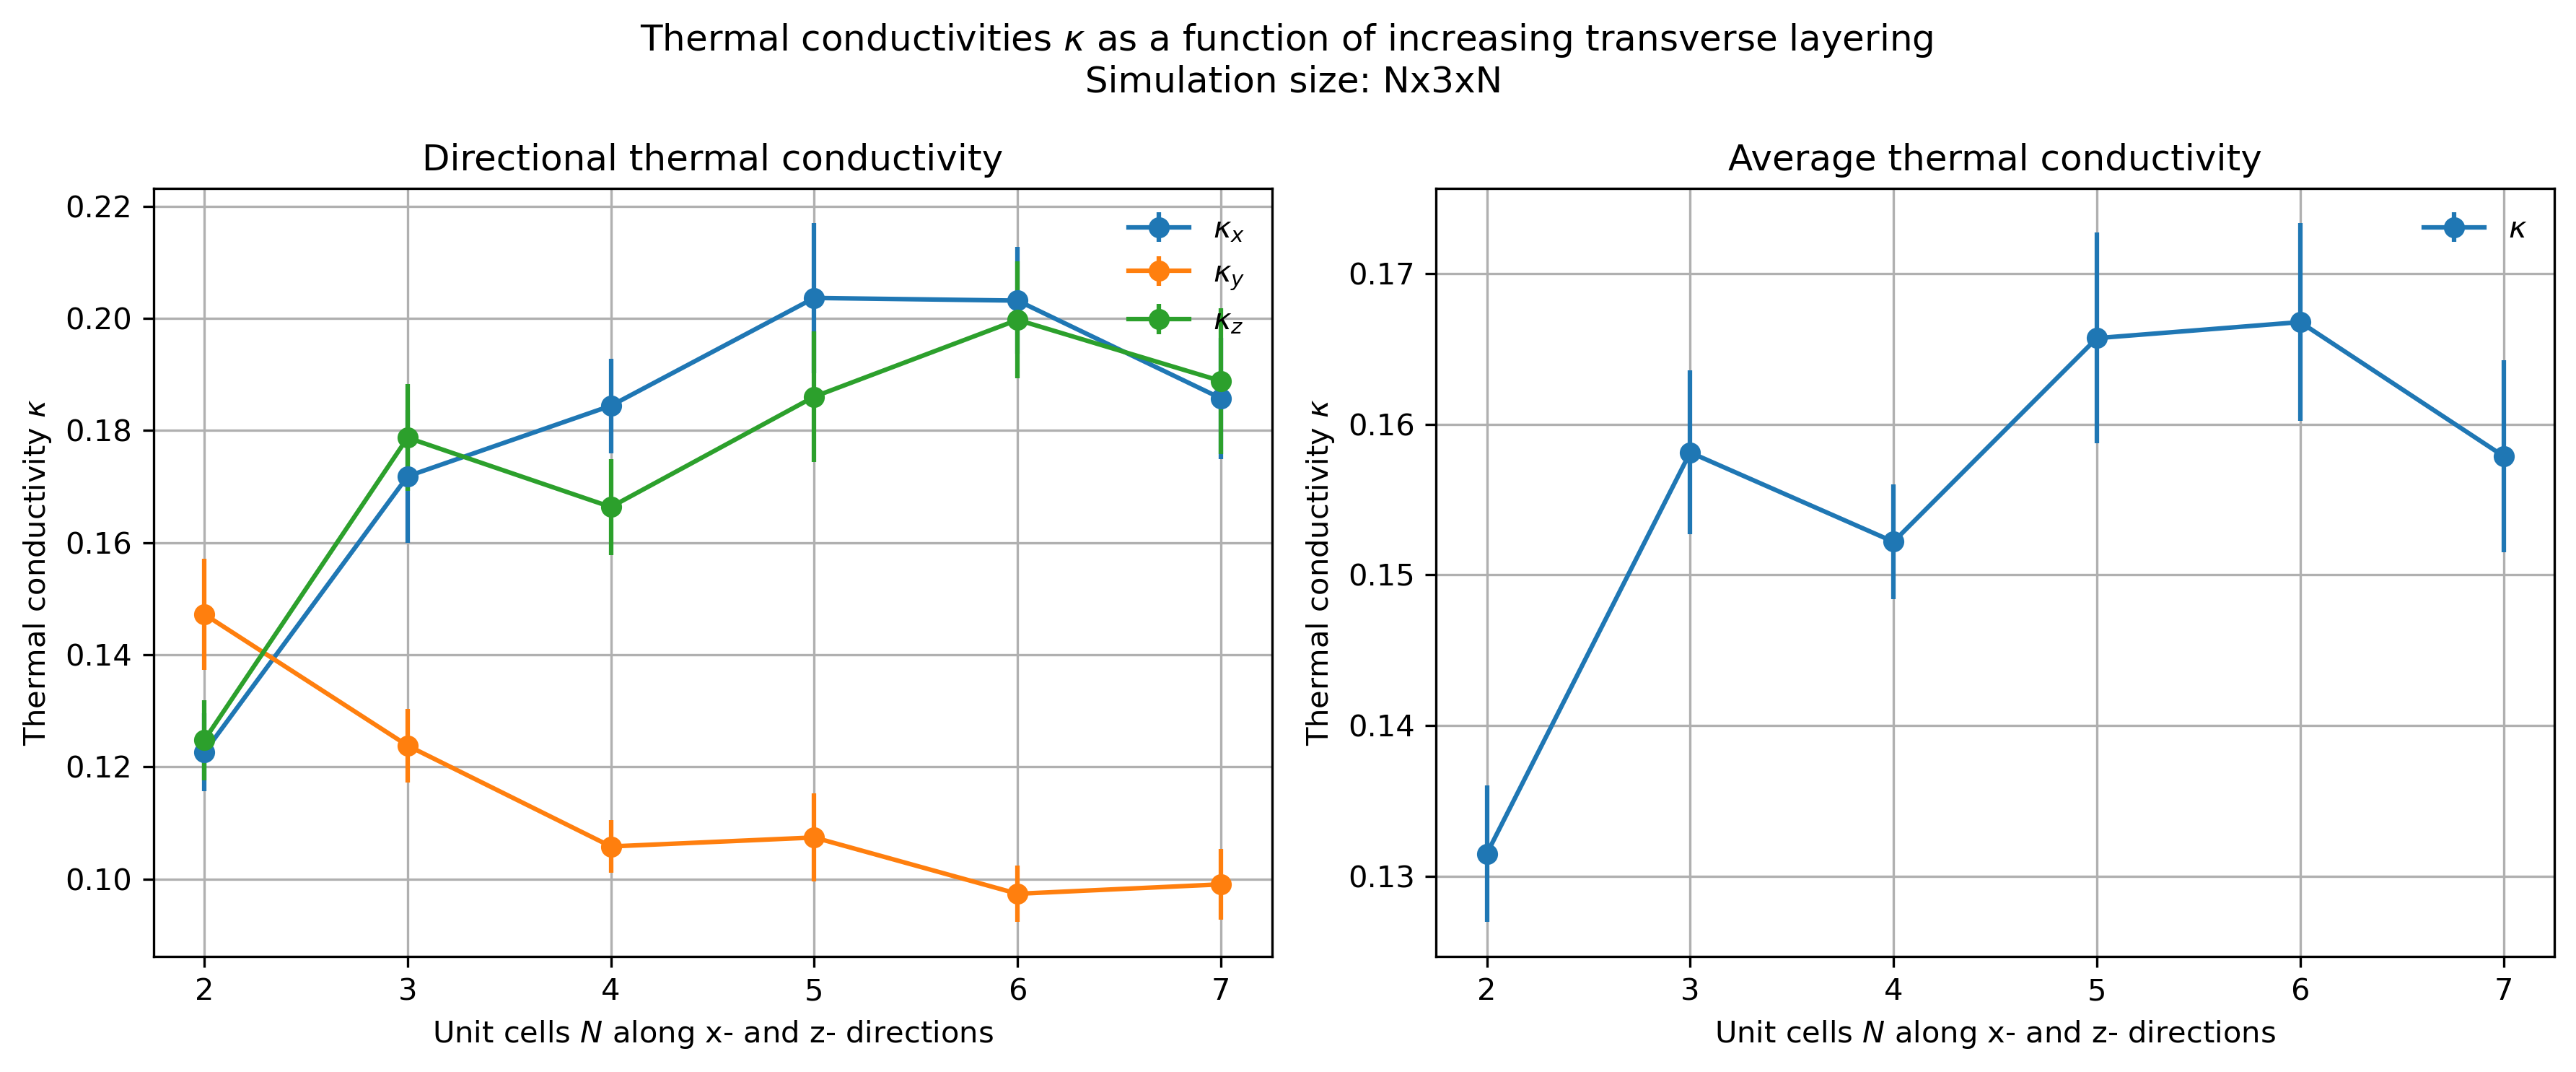

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot directional conductivities
ax1.errorbar(N, kx_averages, yerr=kx_errors, fmt='o-', label=r"$\kappa_x$")
ax1.errorbar(N, ky_averages, yerr=ky_errors, fmt='o-', label=r"$\kappa_y$")
ax1.errorbar(N, kz_averages, yerr=kz_errors, fmt='o-', label=r"$\kappa_z$")
ax1.grid()
ax1.set_xlabel("Unit cells $N$ along x- and z- directions"); ax1.set_ylabel("Thermal conductivity $\kappa$")
ax1.set_title("Directional thermal conductivity")
ax1.legend()

# Plot average conductivities
ax2.errorbar(N, k_averages, yerr=k_errors, fmt='o-', label=r"$\kappa$")
ax2.grid()
ax2.set_xlabel("Unit cells $N$ along x- and z- directions"); ax2.set_ylabel("Thermal conductivity $\kappa$")
ax2.set_title("Average thermal conductivity")
ax2.legend()

plt.suptitle("Thermal conductivities $\kappa$ as a function of increasing transverse layering \n Simulation size: Nx3xN")
plt.tight_layout()

## Nx10xN
Changed to 10 seeds below instead of 20 due to the computational cost.

In [13]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

N = np.array([2,3,4,5,6,7])

# Setup array storage
k_averages, k_errors = [], []
kx_averages, kx_errors = [], []
ky_averages, ky_errors = [], []
kz_averages, kz_errors = [], []

# Loop over increasing layers
for n in tqdm(N):
    # Create datafile for LAMMPS to use
    Ncells = np.array([n,n])
    layered_datafile_creation(Ncells, 10, spacings)
    # Update seeds
    seeds = np.random.randint(1,100000,10)
    # Thermal conductivites per layer
    k_run, kx_run, ky_run, kz_run = [], [], [], []
    # Loop over seeds
    for seed in seeds:
        update_seed("tc.txt", seed)
        run_bash()
        # Extract TC and directional TC
        k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
        # Store all seed TC's
        k_run.append(k_seed)
        kx_run.append(kx_seed)
        ky_run.append(ky_seed)
        kz_run.append(kz_seed)
    # Find all TC averages per layer
    k_averages.append(np.mean(k_run))
    kx_averages.append(np.mean(kx_run))
    ky_averages.append(np.mean(ky_run))
    kz_averages.append(np.mean(kz_run))
    # Also find their errors
    k_errors.append(np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
    kx_errors.append(np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
    ky_errors.append(np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
    kz_errors.append(np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [47:21<00:00, 473.61s/it]


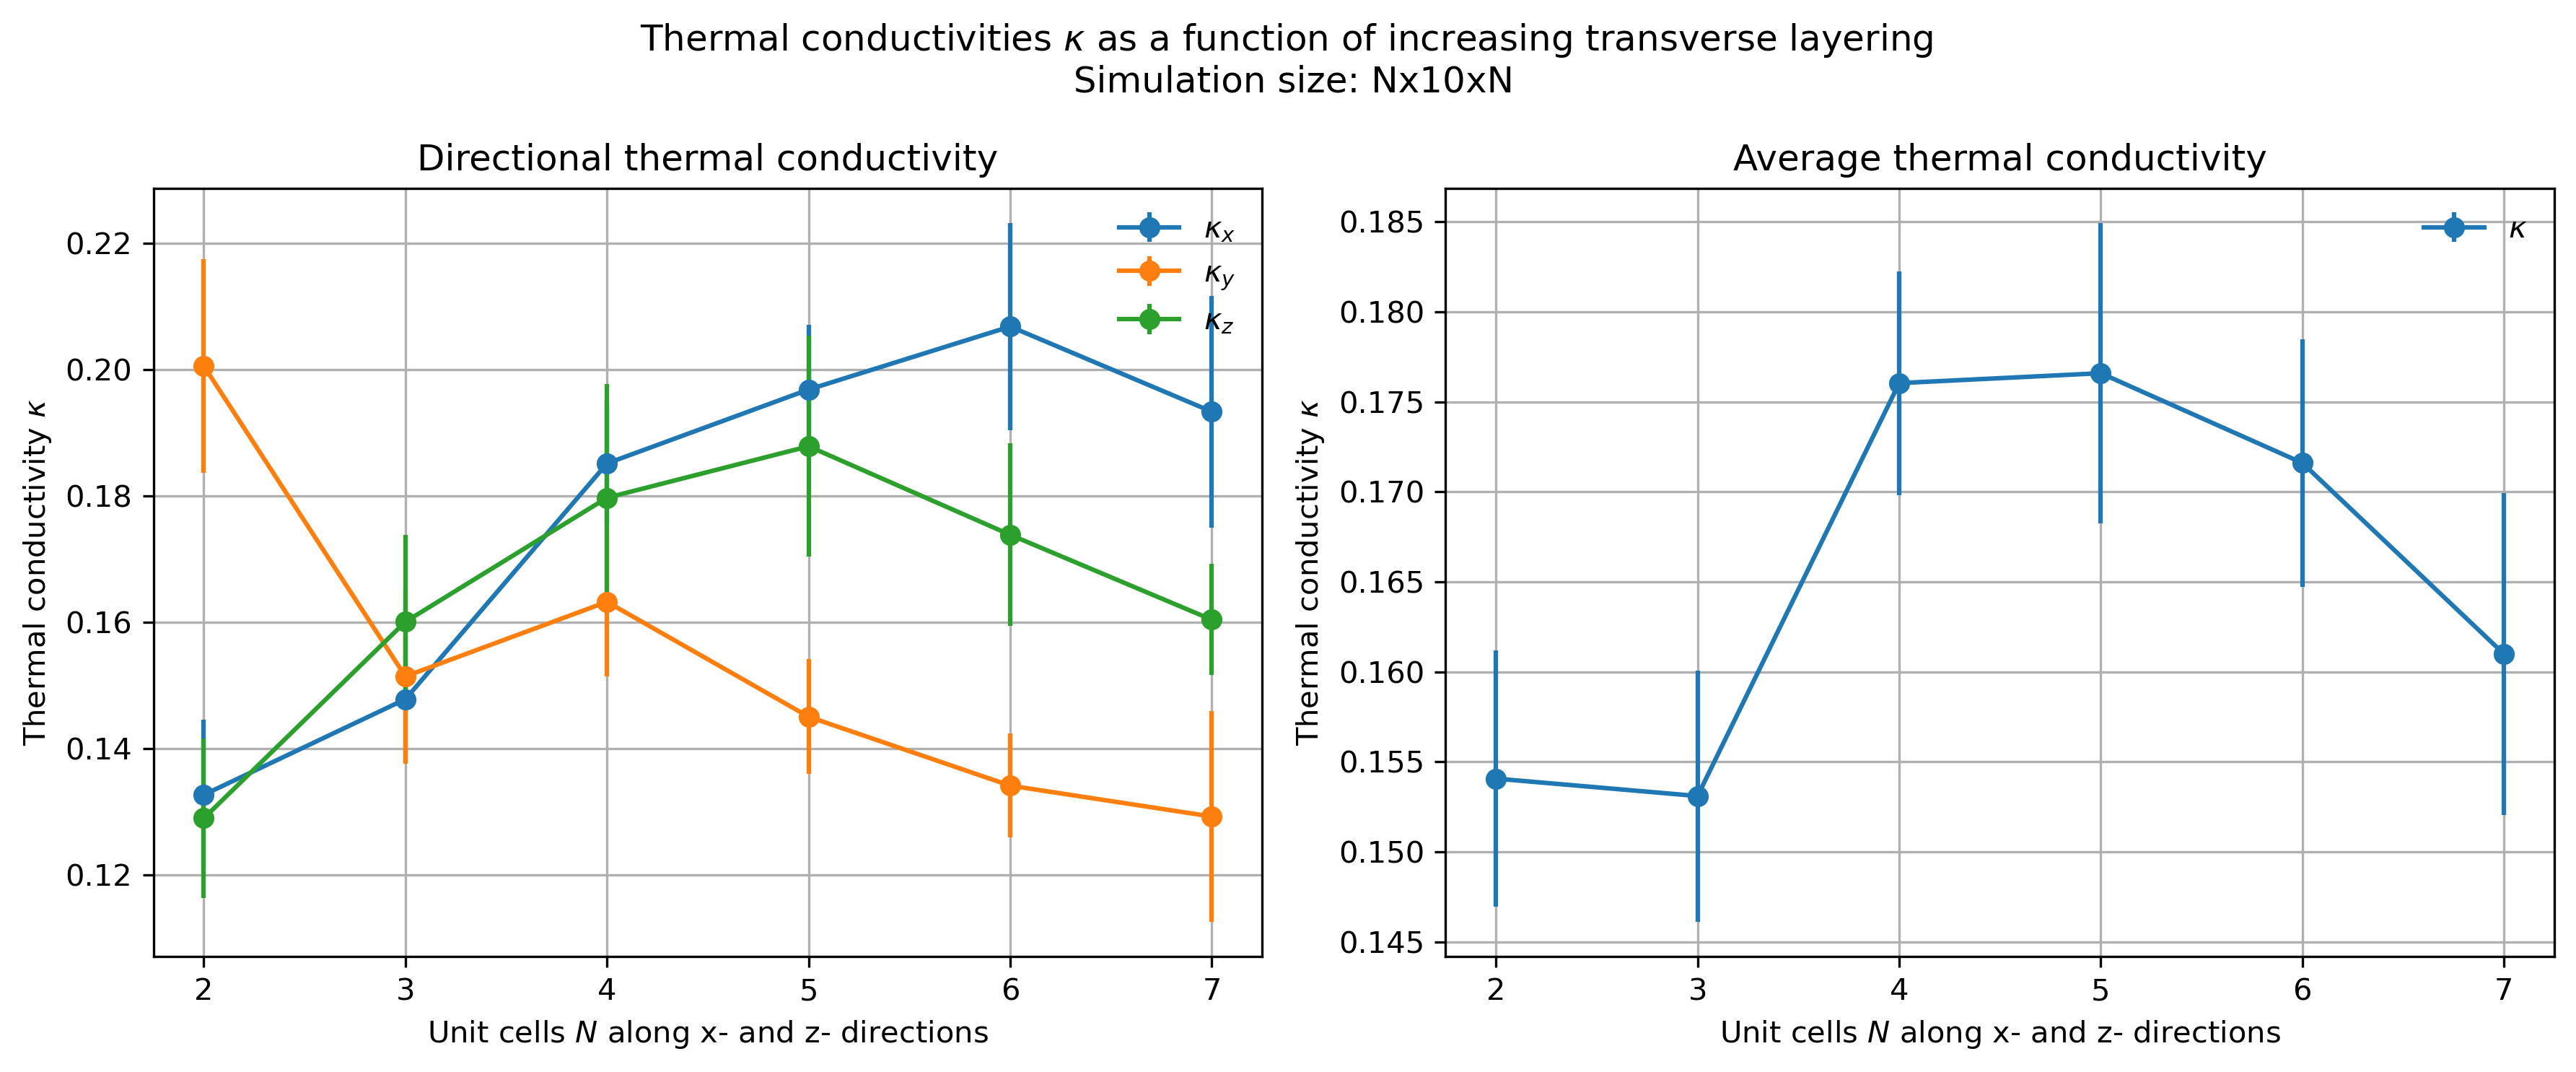

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Plot directional conductivities
ax1.errorbar(N, kx_averages, yerr=kx_errors, fmt='o-', label=r"$\kappa_x$")
ax1.errorbar(N, ky_averages, yerr=ky_errors, fmt='o-', label=r"$\kappa_y$")
ax1.errorbar(N, kz_averages, yerr=kz_errors, fmt='o-', label=r"$\kappa_z$")
ax1.grid()
ax1.set_xlabel("Unit cells $N$ along x- and z- directions"); ax1.set_ylabel("Thermal conductivity $\kappa$")
ax1.set_title("Directional thermal conductivity")
ax1.legend()

# Plot average conductivities
ax2.errorbar(N, k_averages, yerr=k_errors, fmt='o-', label=r"$\kappa$")
ax2.grid()
ax2.set_xlabel("Unit cells $N$ along x- and z- directions"); ax2.set_ylabel("Thermal conductivity $\kappa$")
ax2.set_title("Average thermal conductivity")
ax2.legend()

plt.suptitle("Thermal conductivities $\kappa$ as a function of increasing transverse layering \n Simulation size: Nx10xN")
plt.tight_layout()